<a href="https://colab.research.google.com/github/surensnyper/class_spatial_data_mining/blob/main/Unspecified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install textsearch
!pip install contractions
!pip install textsearch
import nltk
nltk.download('punkt')
nltk.download('stopwords')

     |████████████████████████████████| 287 kB 4.2 MB/s 
     |████████████████████████████████| 106 kB 69.2 MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [29]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Spatial Data Mining Project/2022_january1_january2.csv', encoding_errors='ignore')
# df = pd.read_csv('https://github.com/dipanjanS/nlp_workshop_dhs18/raw/master/Unit%2010%20-%20Project%208%20-%20Movie%20Recommendations%20with%20Document%20Similarity/tmdb_5000_movies.csv.gz', compression='gzip')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  195 non-null    int64  
 1   id          195 non-null    float64
 2   text        195 non-null    object 
 3   longitude   195 non-null    float64
 4   latitude    195 non-null    float64
 5   sentiment   195 non-null    float64
 6   time        195 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 10.8+ KB


In [30]:
df.head()

,Unnamed: 0,id,text,longitude,latitude,sentiment,time
0,0,1.480000e+18,"From my home to yours, near and far, to all my...",-80.666848,43.143148,0.406250,2022-01-01T04:54:58.000Z
1,1,1.480000e+18,#TopNine #BestNine whatever you kids call it. ...,7.483300,9.066700,0.263920,2022-01-01T04:56:37.000Z
2,2,1.480000e+18,It??s almost been two weeks since I??ve been a...,-117.158500,32.715500,0.327841,2022-01-01T05:03:15.000Z
3,3,1.480000e+18,Happy New Year! May 2022 be the year we are fi...,-81.053000,41.771700,0.367614,2022-01-01T05:09:06.000Z
4,4,1.480000e+18,"Home from work, relaxing for the new year with...",-117.158500,32.715500,0.136364,2022-01-01T05:09:37.000Z


In [31]:
df = df[['id', 'text', 'longitude', 'latitude', 'sentiment']]
df.id.fillna('', inplace=True)
# df['description'] = df['Category'].map(str) + ' ' + df['Abstract']
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195 entries, 0 to 194
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         195 non-null    float64
 1   text       195 non-null    object 
 2   longitude  195 non-null    float64
 3   latitude   195 non-null    float64
 4   sentiment  195 non-null    float64
dtypes: float64(4), object(1)
memory usage: 9.1+ KB


In [32]:
df.head()

,id,text,longitude,latitude,sentiment
0,1.480000e+18,"From my home to yours, near and far, to all my...",-80.666848,43.143148,0.406250
1,1.480000e+18,#TopNine #BestNine whatever you kids call it. ...,7.483300,9.066700,0.263920
2,1.480000e+18,It??s almost been two weeks since I??ve been a...,-117.158500,32.715500,0.327841
3,1.480000e+18,Happy New Year! May 2022 be the year we are fi...,-81.053000,41.771700,0.367614
4,1.480000e+18,"Home from work, relaxing for the new year with...",-117.158500,32.715500,0.136364


In [33]:
import nltk
import re
import numpy as np
import contractions

stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    doc = contractions.fix(doc)
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    #filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(list(df['text']))
len(norm_corpus)

195

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

stop_words = stop_words + ['one', 'two', 'three', 'four', 'five', 'get']
cv = CountVectorizer(ngram_range=(1, 2), min_df=0.001, max_df=0.99, stop_words=stop_words)
cv_matrix = cv.fit_transform(norm_corpus)
cv_matrix.shape

(195, 4315)

In [35]:
from sklearn.cluster import KMeans

NUM_CLUSTERS = 3
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=10000, n_init=100, random_state=42).fit(cv_matrix)
km

KMeans(max_iter=10000, n_clusters=3, n_init=100, random_state=42)

In [36]:
from collections import Counter

Counter(km.labels_)

Counter({0: 186, 1: 4, 2: 5})

In [37]:
df['kmeans_cluster'] = km.labels_

In [38]:
movie_clusters = (df[['id', 'kmeans_cluster', 'text']]
                  .sort_values(by=['kmeans_cluster', 'text'], 
                               ascending=False)
                  .groupby('kmeans_cluster').head(20))
movie_clusters = movie_clusters.copy(deep=True)

In [39]:
feature_names = cv.get_feature_names()
topn_features = 30
ordered_centroids = km.cluster_centers_.argsort()[:, ::-1]

# get key features for each cluster
# get movies belonging to each cluster
for cluster_num in range(NUM_CLUSTERS):
    key_features = [feature_names[index] 
                        for index in ordered_centroids[cluster_num, :topn_features]]
    movies = movie_clusters[movie_clusters['kmeans_cluster'] == cluster_num]['id'].values.tolist()
    print('CLUSTER #'+str(cluster_num+1))
    print('Key Features:', key_features)
    print('id:', movies)
    print('-'*80)

CLUSTER #1
Key Features: ['covid', 'year', 'new', '2022', 'covid19', 'new year', 'happy', 'happy new', 'pandemic', 'health', 'us', 'safe', '2021', 'family', 'corona', 'california', 'cases', 'everyone', 'happynewyear', 'amp', 'testing', 'coronavirus', 'quarantine', 'years', 'day', 'center', 'love', 'first', 'well', 'vaccine']
id: [1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18]
--------------------------------------------------------------------------------
CLUSTER #2
Key Features: ['exit', 'avenue', 'hempstead avenue', 'corona', 'corona avenue', '17s hempstead', '17s', 'eb exit', 'eb', 'exit 15', '15 north', '15', 'exit 17s', 'southernstateparkway eb', 'southernstateparkway', 'north', 'hempstead', 'north corona', 'incident', 'avenue exit', 'incident southernstateparkway', 'cleared incident', 'cleared', 'httpstcoqvkvqnw3ws', 'avenue http

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [40]:
from gensim.models import FastText

tokenized_docs = [doc.split() for doc in norm_corpus]
ft_model = FastText(tokenized_docs, size=300, window=40, min_count=2, workers=4, sg=1, iter=100)

In [41]:
def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.
        
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [42]:
doc_vecs_ft = averaged_word2vec_vectorizer(tokenized_docs, ft_model, 300)
doc_vecs_ft.shape

(195, 300)

In [43]:
NUM_CLUSTERS = 6
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=10000, n_init=100, random_state=42).fit(doc_vecs_ft)

In [44]:
Counter(km.labels_)

Counter({0: 45, 1: 12, 2: 27, 3: 6, 4: 40, 5: 65})

In [45]:
df['kmeans_cluster'] = km.labels_
movie_clusters = (df[['id', 'kmeans_cluster', 'text']]
                  .sort_values(by=['kmeans_cluster', 'text'], 
                               ascending=False)
                  .groupby('kmeans_cluster').head(30))
movie_clusters = movie_clusters.copy(deep=True)

In [46]:
for cluster_num in range(NUM_CLUSTERS):
    movies = movie_clusters[movie_clusters['kmeans_cluster'] == cluster_num]['id'].values.tolist()
    print('CLUSTER #'+str(cluster_num+1))
    print('id:', movies)
    print('-'*80)

CLUSTER #1
id: [1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18]
--------------------------------------------------------------------------------
CLUSTER #2
id: [1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18]
--------------------------------------------------------------------------------
CLUSTER #3
id: [1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18, 1.48e+18]
--------------------------------------------------------------------------------
CLUSTER #4
id: [1.4

In [47]:
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity

In [48]:
def ward_hierarchical_clustering(feature_matrix):
    
    cosine_distance = 1 - cosine_similarity(feature_matrix)
    linkage_matrix = ward(cosine_distance)
    return linkage_matrix

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_hierarchical_clusters(linkage_matrix, paper_data, p=100, figure_size=(8,12)):
    # set size
    fig, ax = plt.subplots(figsize=figure_size) 
    paper_titles = paper_data['id'].values.tolist()
    # plot dendrogram
    R = dendrogram(linkage_matrix, orientation="left", labels=paper_titles,
                    truncate_mode='lastp', 
                    p=p,  
                    no_plot=True)
    temp = {R["leaves"][ii]: paper_titles[ii] for ii in range(len(R["leaves"]))}
    def llf(xx):
        return "{}".format(temp[xx])
    ax = dendrogram(
            linkage_matrix,
            truncate_mode='lastp',
            orientation="left",
            p=p,  
            leaf_label_func=llf, 
            leaf_font_size=10.,
            )
    plt.tick_params(axis= 'x',   
                    which='both',  
                    bottom='off',
                    top='off',
                    labelbottom='off')
    plt.tight_layout()
    plt.savefig('tweet_id_hierachical_clusters.png', dpi=200)

In [50]:
linkage_matrix = ward_hierarchical_clustering(doc_vecs_ft)

In [51]:
np.set_printoptions(suppress=True)
print(linkage_matrix)

[[118.         119.           0.           2.        ]
 [ 32.          44.           0.           2.        ]
 [166.         196.           0.           3.        ]
 [ 61.          62.           0.           2.        ]
 [ 69.          70.           0.           2.        ]
 [107.         117.           0.           2.        ]
 [108.         115.           0.           2.        ]
 [ 83.         111.           0.0343977    2.        ]
 [198.         199.           0.03490344   4.        ]
 [ 84.         202.           0.11319935   3.        ]
 [136.         137.           0.23345423   2.        ]
 [ 66.          82.           0.24984994   2.        ]
 [105.         177.           0.31319676   2.        ]
 [ 58.         204.           0.34873832   4.        ]
 [ 54.         104.           0.40427348   2.        ]
 [ 63.          73.           0.42535926   2.        ]
 [ 85.          89.           0.44130487   2.        ]
 [ 14.          25.           0.55185641   2.        ]
 [148.    

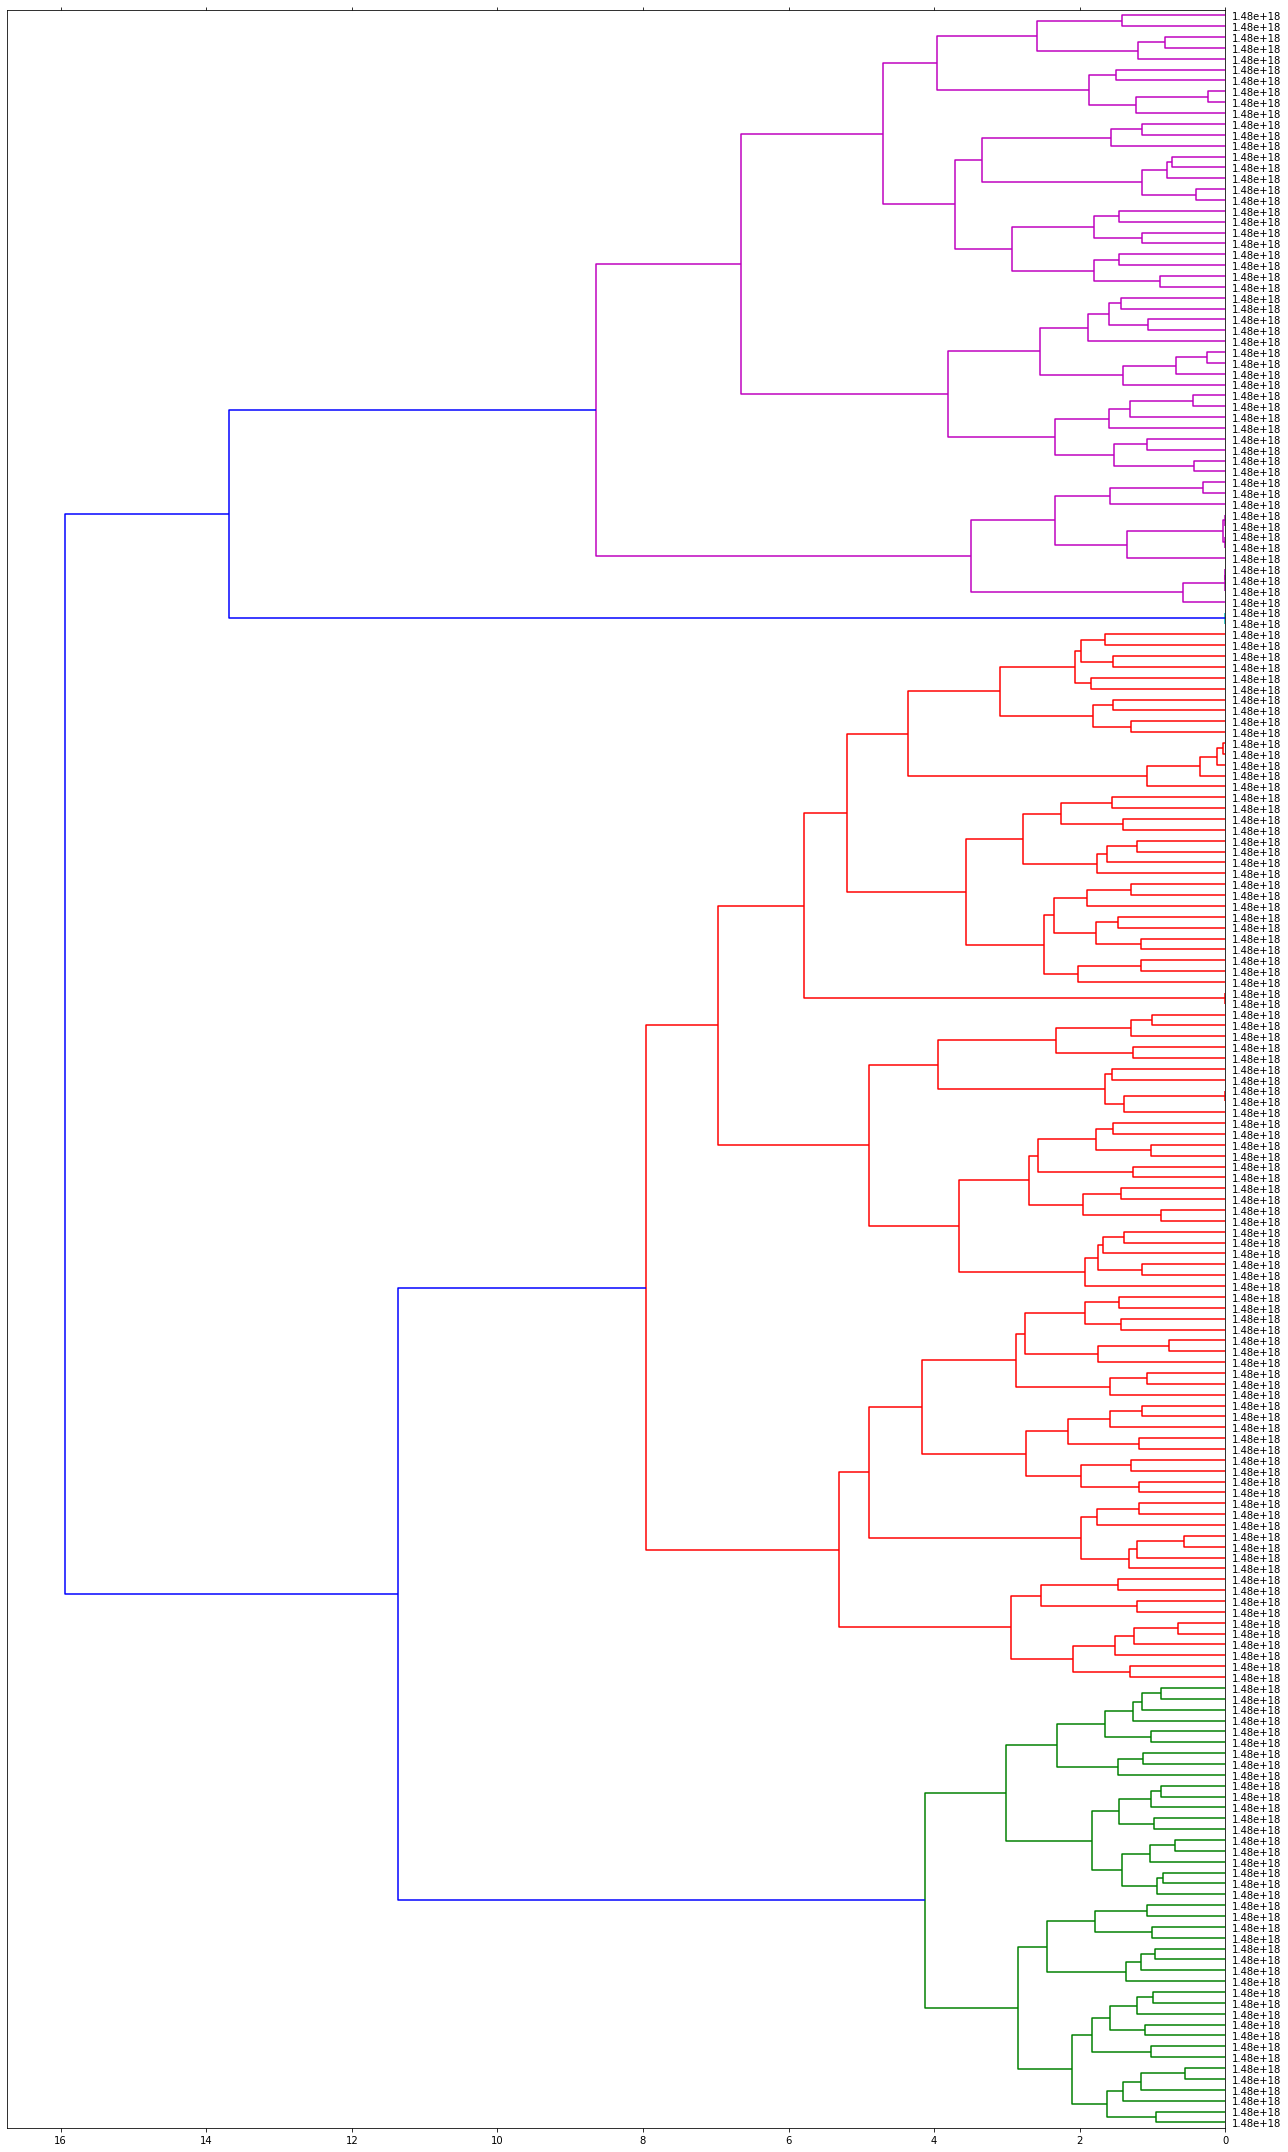

In [52]:
plot_hierarchical_clusters(linkage_matrix,
                           p=200,
                           paper_data=df,
                           figure_size=(18, 30))